In [1]:
### PREAMBLE
# Chapter 1 - Introduction to adversarial robustness
# noise.jpg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from inspect import getfullargspec,signature

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import datasets


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [1]:
###THis file is to generate standard model ############

In [4]:
####################################
#Need to run the same with FashionMNIST
###################################


############################
class MnistResNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MnistResNet, self).__init__()

    # Load a pretrained resnet model from torchvision.models in Pytorch
    self.model = models.resnet50(pretrained=False)

    # Change the input layer to take Grayscale image, instead of RGB images.  **************
    # Hence in_channels is set as 1 or 3 respectively
    # original definition of the first layer on the ResNet class
    # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Change the output layer to output 10 classes instead of 1000 classes
    num_ftrs = self.model.fc.in_features
    self.model.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.model(x)


my_resnet = MnistResNet()

input = torch.randn((16,1,244,244))
output = my_resnet(input)
print(output.shape)

print(my_resnet)

torch.Size([16, 10])
MnistResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

def get_data_loaders(train_batch_size, val_batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))
                                        ])

    train_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.FashionMNIST(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader


def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in signature(metric_fn).parameters:
        return metric_fn(true_y, pred_y, average="micro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")
        
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [6]:
print(torch.cuda.is_available())

True


In [7]:
# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
#norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet18, and put into evaluation mode (necessary to e.g. turn off batchnorm)
#model = resnet50(pretrained=True)
#model.eval();
# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 120
batch_size = 128

# Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

start_ts = time.time()

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...


/home/ashraf.haddad/.conda/envs/rob/lib/python3.9/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378073850/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


/home/ashraf.haddad/.conda/envs/rob/lib/python3.9/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
# IF PRETRAINED  SKIP THIS SECTION

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  ----------------- 
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, accuracy), 
                                   (precision_score, recall_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

            


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/120, training loss: 0.4644469823727984, validation loss: 0.35985231399536133
	     precision: 0.8671
	        recall: 0.8671
	            F1: 0.0000
	      accuracy: 0.8671


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/120, training loss: 0.2660579351124479, validation loss: 0.2677856683731079
	     precision: 0.9041
	        recall: 0.9041
	            F1: 0.0000
	      accuracy: 0.9041


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/120, training loss: 0.2232319218422304, validation loss: 0.2517159581184387
	     precision: 0.9095
	        recall: 0.9095
	            F1: 0.0000
	      accuracy: 0.9095


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/120, training loss: 0.19635340045573615, validation loss: 0.26906222105026245
	     precision: 0.9051
	        recall: 0.9051
	            F1: 0.0000
	      accuracy: 0.9051


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/120, training loss: 0.1762573650237848, validation loss: 0.2585529088973999
	     precision: 0.9109
	        recall: 0.9109
	            F1: 0.0000
	      accuracy: 0.9109


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/120, training loss: 0.15653520016305483, validation loss: 0.261597603559494
	     precision: 0.9146
	        recall: 0.9146
	            F1: 0.0000
	      accuracy: 0.9146


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/120, training loss: 0.14166899541738445, validation loss: 0.35142603516578674
	     precision: 0.8815
	        recall: 0.8815
	            F1: 0.0000
	      accuracy: 0.8815


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/120, training loss: 0.12355702453807219, validation loss: 0.3021107017993927
	     precision: 0.9081
	        recall: 0.9081
	            F1: 0.0000
	      accuracy: 0.9081


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/120, training loss: 0.1096255364440588, validation loss: 0.3125896453857422
	     precision: 0.9038
	        recall: 0.9038
	            F1: 0.0000
	      accuracy: 0.9038


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/120, training loss: 0.09168635210050131, validation loss: 0.2621440887451172
	     precision: 0.9188
	        recall: 0.9188
	            F1: 0.0000
	      accuracy: 0.9188


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/120, training loss: 0.08158459679197783, validation loss: 0.2745835781097412
	     precision: 0.9200
	        recall: 0.9200
	            F1: 0.0000
	      accuracy: 0.9200


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/120, training loss: 0.06657414782299861, validation loss: 0.3287678062915802
	     precision: 0.9207
	        recall: 0.9207
	            F1: 0.0000
	      accuracy: 0.9207


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/120, training loss: 0.05965344233811696, validation loss: 0.3223511874675751
	     precision: 0.9133
	        recall: 0.9133
	            F1: 0.0000
	      accuracy: 0.9133


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/120, training loss: 0.05282472020416244, validation loss: 0.31839627027511597
	     precision: 0.9212
	        recall: 0.9212
	            F1: 0.0000
	      accuracy: 0.9212


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/120, training loss: 0.04221026380898864, validation loss: 0.3671431541442871
	     precision: 0.9139
	        recall: 0.9139
	            F1: 0.0000
	      accuracy: 0.9139


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/120, training loss: 0.04146985695717225, validation loss: 0.33175256848335266
	     precision: 0.9279
	        recall: 0.9279
	            F1: 0.0000
	      accuracy: 0.9279


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/120, training loss: 0.03729773733441208, validation loss: 0.3265477418899536
	     precision: 0.9288
	        recall: 0.9288
	            F1: 0.0000
	      accuracy: 0.9288


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/120, training loss: 0.02989293606234476, validation loss: 0.35642677545547485
	     precision: 0.9257
	        recall: 0.9257
	            F1: 0.0000
	      accuracy: 0.9257


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/120, training loss: 0.03513385023142813, validation loss: 0.3539409041404724
	     precision: 0.9258
	        recall: 0.9258
	            F1: 0.0000
	      accuracy: 0.9258


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/120, training loss: 0.02477533215317311, validation loss: 0.39797961711883545
	     precision: 0.9140
	        recall: 0.9140
	            F1: 0.0000
	      accuracy: 0.9140


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/120, training loss: 0.030000785156202785, validation loss: 0.34843799471855164
	     precision: 0.9240
	        recall: 0.9240
	            F1: 0.0000
	      accuracy: 0.9240


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/120, training loss: 0.02563097415221875, validation loss: 0.35832223296165466
	     precision: 0.9241
	        recall: 0.9241
	            F1: 0.0000
	      accuracy: 0.9241


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/120, training loss: 0.02400990684880619, validation loss: 0.40554630756378174
	     precision: 0.9252
	        recall: 0.9252
	            F1: 0.0000
	      accuracy: 0.9252


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/120, training loss: 0.02242426109512144, validation loss: 0.43116721510887146
	     precision: 0.9172
	        recall: 0.9172
	            F1: 0.0000
	      accuracy: 0.9172


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/120, training loss: 0.01954415346629722, validation loss: 0.548581063747406
	     precision: 0.8816
	        recall: 0.8816
	            F1: 0.0000
	      accuracy: 0.8816


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/120, training loss: 0.02379358881261142, validation loss: 0.3807659447193146
	     precision: 0.9240
	        recall: 0.9240
	            F1: 0.0000
	      accuracy: 0.9240


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/120, training loss: 0.020664662574208143, validation loss: 0.3692496120929718
	     precision: 0.9222
	        recall: 0.9222
	            F1: 0.0000
	      accuracy: 0.9222


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/120, training loss: 0.01996009144640373, validation loss: 0.3961975574493408
	     precision: 0.9206
	        recall: 0.9206
	            F1: 0.0000
	      accuracy: 0.9206


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/120, training loss: 0.01809622823832376, validation loss: 0.428779661655426
	     precision: 0.9229
	        recall: 0.9229
	            F1: 0.0000
	      accuracy: 0.9229


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/120, training loss: 0.015390254071024286, validation loss: 0.4683581590652466
	     precision: 0.9191
	        recall: 0.9191
	            F1: 0.0000
	      accuracy: 0.9191


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31/120, training loss: 0.01919726457626525, validation loss: 0.4548836946487427
	     precision: 0.9232
	        recall: 0.9232
	            F1: 0.0000
	      accuracy: 0.9232


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32/120, training loss: 0.014226094764950343, validation loss: 0.45913276076316833
	     precision: 0.9215
	        recall: 0.9215
	            F1: 0.0000
	      accuracy: 0.9215


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33/120, training loss: 0.016278815661478332, validation loss: 0.42339274287223816
	     precision: 0.9241
	        recall: 0.9241
	            F1: 0.0000
	      accuracy: 0.9241


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34/120, training loss: 0.012459572247670232, validation loss: 0.4378015100955963
	     precision: 0.9273
	        recall: 0.9273
	            F1: 0.0000
	      accuracy: 0.9273


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35/120, training loss: 0.015489879058583874, validation loss: 0.420406699180603
	     precision: 0.9290
	        recall: 0.9290
	            F1: 0.0000
	      accuracy: 0.9290


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36/120, training loss: 0.01526347821233078, validation loss: 0.4692690372467041
	     precision: 0.9260
	        recall: 0.9260
	            F1: 0.0000
	      accuracy: 0.9260


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37/120, training loss: 0.013487774062917745, validation loss: 0.4267728328704834
	     precision: 0.9288
	        recall: 0.9288
	            F1: 0.0000
	      accuracy: 0.9288


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38/120, training loss: 0.00901809554211943, validation loss: 0.4446648359298706
	     precision: 0.9302
	        recall: 0.9302
	            F1: 0.0000
	      accuracy: 0.9302


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39/120, training loss: 0.011747110588144068, validation loss: 0.4469318389892578
	     precision: 0.9291
	        recall: 0.9291
	            F1: 0.0000
	      accuracy: 0.9291


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40/120, training loss: 0.01417816561249421, validation loss: 0.4800475537776947
	     precision: 0.9187
	        recall: 0.9187
	            F1: 0.0000
	      accuracy: 0.9187


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41/120, training loss: 0.01502569476476382, validation loss: 0.4271169900894165
	     precision: 0.9317
	        recall: 0.9317
	            F1: 0.0000
	      accuracy: 0.9317


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42/120, training loss: 0.007528782693574814, validation loss: 0.4369930028915405
	     precision: 0.9322
	        recall: 0.9322
	            F1: 0.0000
	      accuracy: 0.9322


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43/120, training loss: 0.011473457613955379, validation loss: 0.48469191789627075
	     precision: 0.9251
	        recall: 0.9251
	            F1: 0.0000
	      accuracy: 0.9251


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44/120, training loss: 0.013525380116807588, validation loss: 0.46669095754623413
	     precision: 0.9233
	        recall: 0.9233
	            F1: 0.0000
	      accuracy: 0.9233


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45/120, training loss: 0.009644890063005299, validation loss: 0.4742913544178009
	     precision: 0.9249
	        recall: 0.9249
	            F1: 0.0000
	      accuracy: 0.9249


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46/120, training loss: 0.008847867933632585, validation loss: 0.5700260400772095
	     precision: 0.9129
	        recall: 0.9129
	            F1: 0.0000
	      accuracy: 0.9129


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47/120, training loss: 0.012050783811429825, validation loss: 0.45290607213974
	     precision: 0.9240
	        recall: 0.9240
	            F1: 0.0000
	      accuracy: 0.9240


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48/120, training loss: 0.009675277799013818, validation loss: 0.44370946288108826
	     precision: 0.9315
	        recall: 0.9315
	            F1: 0.0000
	      accuracy: 0.9315


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49/120, training loss: 0.006282976676827715, validation loss: 0.4972209334373474
	     precision: 0.9256
	        recall: 0.9256
	            F1: 0.0000
	      accuracy: 0.9256


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50/120, training loss: 0.013198246190626695, validation loss: 0.48467758297920227
	     precision: 0.9235
	        recall: 0.9235
	            F1: 0.0000
	      accuracy: 0.9235


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51/120, training loss: 0.00776084201190319, validation loss: 0.46425533294677734
	     precision: 0.9330
	        recall: 0.9330
	            F1: 0.0000
	      accuracy: 0.9330


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52/120, training loss: 0.005360439498637792, validation loss: 0.5297508239746094
	     precision: 0.9213
	        recall: 0.9213
	            F1: 0.0000
	      accuracy: 0.9213


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53/120, training loss: 0.01673441258158154, validation loss: 0.4700550138950348
	     precision: 0.9269
	        recall: 0.9269
	            F1: 0.0000
	      accuracy: 0.9269


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54/120, training loss: 0.004166130242745698, validation loss: 0.5190841555595398
	     precision: 0.9237
	        recall: 0.9237
	            F1: 0.0000
	      accuracy: 0.9237


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55/120, training loss: 0.008111951232440566, validation loss: 0.5122334361076355
	     precision: 0.9235
	        recall: 0.9235
	            F1: 0.0000
	      accuracy: 0.9235


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56/120, training loss: 0.011132386441256649, validation loss: 0.49952858686447144
	     precision: 0.9277
	        recall: 0.9277
	            F1: 0.0000
	      accuracy: 0.9277


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57/120, training loss: 0.006696448655418044, validation loss: 0.4908679127693176
	     precision: 0.9231
	        recall: 0.9231
	            F1: 0.0000
	      accuracy: 0.9231


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58/120, training loss: 0.005719581289838637, validation loss: 0.4994812607765198
	     precision: 0.9265
	        recall: 0.9265
	            F1: 0.0000
	      accuracy: 0.9265


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59/120, training loss: 0.008163528251013647, validation loss: 0.5596000552177429
	     precision: 0.9206
	        recall: 0.9206
	            F1: 0.0000
	      accuracy: 0.9206


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60/120, training loss: 0.01058198654559099, validation loss: 0.47889062762260437
	     precision: 0.9285
	        recall: 0.9285
	            F1: 0.0000
	      accuracy: 0.9285


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 61/120, training loss: 0.0057566693518729655, validation loss: 0.5102301836013794
	     precision: 0.9276
	        recall: 0.9276
	            F1: 0.0000
	      accuracy: 0.9276


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 62/120, training loss: 0.005441740766381079, validation loss: 0.5190756320953369
	     precision: 0.9211
	        recall: 0.9211
	            F1: 0.0000
	      accuracy: 0.9211


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 63/120, training loss: 0.006663287273947248, validation loss: 0.5066889524459839
	     precision: 0.9238
	        recall: 0.9238
	            F1: 0.0000
	      accuracy: 0.9238


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 64/120, training loss: 0.008536654209094703, validation loss: 0.47482678294181824
	     precision: 0.9314
	        recall: 0.9314
	            F1: 0.0000
	      accuracy: 0.9314


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 65/120, training loss: 0.005645578336765759, validation loss: 0.5322332382202148
	     precision: 0.9241
	        recall: 0.9241
	            F1: 0.0000
	      accuracy: 0.9241


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 66/120, training loss: 0.008289781047875365, validation loss: 0.48371556401252747
	     precision: 0.9237
	        recall: 0.9237
	            F1: 0.0000
	      accuracy: 0.9237


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 67/120, training loss: 0.007288290535550697, validation loss: 0.5915786623954773
	     precision: 0.9203
	        recall: 0.9203
	            F1: 0.0000
	      accuracy: 0.9203


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 68/120, training loss: 0.007294560882756627, validation loss: 0.49299192428588867
	     precision: 0.9260
	        recall: 0.9260
	            F1: 0.0000
	      accuracy: 0.9260


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 69/120, training loss: 0.00615711721144056, validation loss: 0.5088396072387695
	     precision: 0.9235
	        recall: 0.9235
	            F1: 0.0000
	      accuracy: 0.9235


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 70/120, training loss: 0.005357586122433991, validation loss: 0.6049361824989319
	     precision: 0.9176
	        recall: 0.9176
	            F1: 0.0000
	      accuracy: 0.9176


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 71/120, training loss: 0.007611181955743106, validation loss: 0.47529178857803345
	     precision: 0.9289
	        recall: 0.9289
	            F1: 0.0000
	      accuracy: 0.9289


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 72/120, training loss: 0.005470002460958113, validation loss: 0.5229882001876831
	     precision: 0.9265
	        recall: 0.9265
	            F1: 0.0000
	      accuracy: 0.9265


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 73/120, training loss: 0.008074852570766169, validation loss: 0.48253270983695984
	     precision: 0.9283
	        recall: 0.9283
	            F1: 0.0000
	      accuracy: 0.9283


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 74/120, training loss: 0.0038743211051639006, validation loss: 0.4839005768299103
	     precision: 0.9293
	        recall: 0.9293
	            F1: 0.0000
	      accuracy: 0.9293


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 75/120, training loss: 0.005409947304926792, validation loss: 0.5308493971824646
	     precision: 0.9282
	        recall: 0.9282
	            F1: 0.0000
	      accuracy: 0.9282


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 76/120, training loss: 0.006314831871621671, validation loss: 0.5718969702720642
	     precision: 0.9214
	        recall: 0.9214
	            F1: 0.0000
	      accuracy: 0.9214


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 77/120, training loss: 0.006513459483549517, validation loss: 0.5901318192481995
	     precision: 0.9084
	        recall: 0.9084
	            F1: 0.0000
	      accuracy: 0.9084


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 78/120, training loss: 0.006464621896961818, validation loss: 0.5161383748054504
	     precision: 0.9258
	        recall: 0.9258
	            F1: 0.0000
	      accuracy: 0.9258


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 79/120, training loss: 0.0023395694081437524, validation loss: 0.5175452828407288
	     precision: 0.9276
	        recall: 0.9276
	            F1: 0.0000
	      accuracy: 0.9276


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 80/120, training loss: 0.0020100055680464905, validation loss: 0.5704599022865295
	     precision: 0.9278
	        recall: 0.9278
	            F1: 0.0000
	      accuracy: 0.9278


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 81/120, training loss: 0.011215824654150088, validation loss: 0.4900955557823181
	     precision: 0.9275
	        recall: 0.9275
	            F1: 0.0000
	      accuracy: 0.9275


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 82/120, training loss: 0.0020144499886828853, validation loss: 0.5259016156196594
	     precision: 0.9289
	        recall: 0.9289
	            F1: 0.0000
	      accuracy: 0.9289


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 83/120, training loss: 0.003159148717063225, validation loss: 0.5430601835250854
	     precision: 0.9269
	        recall: 0.9269
	            F1: 0.0000
	      accuracy: 0.9269


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 84/120, training loss: 0.0084814316191015, validation loss: 0.5136361122131348
	     precision: 0.9307
	        recall: 0.9307
	            F1: 0.0000
	      accuracy: 0.9307


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 85/120, training loss: 0.0027195047519230227, validation loss: 0.5324432849884033
	     precision: 0.9303
	        recall: 0.9303
	            F1: 0.0000
	      accuracy: 0.9303


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 86/120, training loss: 0.0031616589843090283, validation loss: 0.5644744634628296
	     precision: 0.9289
	        recall: 0.9289
	            F1: 0.0000
	      accuracy: 0.9289


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 87/120, training loss: 0.00849312986171418, validation loss: 0.5070960521697998
	     precision: 0.9269
	        recall: 0.9269
	            F1: 0.0000
	      accuracy: 0.9269


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 88/120, training loss: 0.00499454044736278, validation loss: 0.49178406596183777
	     precision: 0.9325
	        recall: 0.9325
	            F1: 0.0000
	      accuracy: 0.9325


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 89/120, training loss: 0.0018609626972497385, validation loss: 0.48070386052131653
	     precision: 0.9334
	        recall: 0.9334
	            F1: 0.0000
	      accuracy: 0.9334


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 90/120, training loss: 0.002500894982457462, validation loss: 0.7014473080635071
	     precision: 0.9149
	        recall: 0.9149
	            F1: 0.0000
	      accuracy: 0.9149


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 91/120, training loss: 0.015029801007089333, validation loss: 0.49218764901161194
	     precision: 0.9262
	        recall: 0.9262
	            F1: 0.0000
	      accuracy: 0.9262


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 92/120, training loss: 0.0009588072667409735, validation loss: 0.4769231081008911
	     precision: 0.9329
	        recall: 0.9329
	            F1: 0.0000
	      accuracy: 0.9329


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 93/120, training loss: 0.0001975116401508339, validation loss: 0.4790862500667572
	     precision: 0.9316
	        recall: 0.9316
	            F1: 0.0000
	      accuracy: 0.9316


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 94/120, training loss: 0.0003263349500093876, validation loss: 0.5047551989555359
	     precision: 0.9316
	        recall: 0.9316
	            F1: 0.0000
	      accuracy: 0.9316


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 95/120, training loss: 0.0042634983005747995, validation loss: 0.6963485479354858
	     precision: 0.9030
	        recall: 0.9030
	            F1: 0.0000
	      accuracy: 0.9030


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 96/120, training loss: 0.014422086374879791, validation loss: 0.428230345249176
	     precision: 0.9344
	        recall: 0.9344
	            F1: 0.0000
	      accuracy: 0.9344


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 97/120, training loss: 0.0024963948760658218, validation loss: 0.47146254777908325
	     precision: 0.9321
	        recall: 0.9321
	            F1: 0.0000
	      accuracy: 0.9321


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 98/120, training loss: 0.003369910511074951, validation loss: 0.5441860556602478
	     precision: 0.9252
	        recall: 0.9252
	            F1: 0.0000
	      accuracy: 0.9252


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 99/120, training loss: 0.004592013719100186, validation loss: 0.5190074443817139
	     precision: 0.9266
	        recall: 0.9266
	            F1: 0.0000
	      accuracy: 0.9266


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 100/120, training loss: 0.0046981020039307386, validation loss: 0.5061975717544556
	     precision: 0.9337
	        recall: 0.9337
	            F1: 0.0000
	      accuracy: 0.9337


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 101/120, training loss: 0.006069256588586185, validation loss: 0.5143988728523254
	     precision: 0.9292
	        recall: 0.9292
	            F1: 0.0000
	      accuracy: 0.9292


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 102/120, training loss: 0.0037858454591113183, validation loss: 0.5198071002960205
	     precision: 0.9330
	        recall: 0.9330
	            F1: 0.0000
	      accuracy: 0.9330


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 103/120, training loss: 0.0011324359575092516, validation loss: 0.5386353135108948
	     precision: 0.9322
	        recall: 0.9322
	            F1: 0.0000
	      accuracy: 0.9322


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 104/120, training loss: 0.004709038787263007, validation loss: 0.5551421046257019
	     precision: 0.9260
	        recall: 0.9260
	            F1: 0.0000
	      accuracy: 0.9260


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 105/120, training loss: 0.004569377952280418, validation loss: 0.5318498611450195
	     precision: 0.9284
	        recall: 0.9284
	            F1: 0.0000
	      accuracy: 0.9284


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 106/120, training loss: 0.003977040935139751, validation loss: 0.5355211496353149
	     precision: 0.9270
	        recall: 0.9270
	            F1: 0.0000
	      accuracy: 0.9270


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 107/120, training loss: 0.002154544849004235, validation loss: 0.5650300979614258
	     precision: 0.9265
	        recall: 0.9265
	            F1: 0.0000
	      accuracy: 0.9265


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 108/120, training loss: 0.0065367984014607725, validation loss: 0.5344403982162476
	     precision: 0.9295
	        recall: 0.9295
	            F1: 0.0000
	      accuracy: 0.9295


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 109/120, training loss: 0.002340127580227059, validation loss: 0.5172938108444214
	     precision: 0.9311
	        recall: 0.9311
	            F1: 0.0000
	      accuracy: 0.9311


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 110/120, training loss: 0.0015809149381448683, validation loss: 0.5601757168769836
	     precision: 0.9278
	        recall: 0.9278
	            F1: 0.0000
	      accuracy: 0.9278


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 111/120, training loss: 0.008691176995396382, validation loss: 0.5213150382041931
	     precision: 0.9311
	        recall: 0.9311
	            F1: 0.0000
	      accuracy: 0.9311


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 112/120, training loss: 0.003200873861959423, validation loss: 0.5249195694923401
	     precision: 0.9304
	        recall: 0.9304
	            F1: 0.0000
	      accuracy: 0.9304


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 113/120, training loss: 0.0021511652471858794, validation loss: 0.5247372388839722
	     precision: 0.9315
	        recall: 0.9315
	            F1: 0.0000
	      accuracy: 0.9315


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 114/120, training loss: 0.00013915642257982048, validation loss: 0.5304470658302307
	     precision: 0.9318
	        recall: 0.9318
	            F1: 0.0000
	      accuracy: 0.9318


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 115/120, training loss: 4.9231913916205894e-05, validation loss: 0.5449531078338623
	     precision: 0.9332
	        recall: 0.9332
	            F1: 0.0000
	      accuracy: 0.9332


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 116/120, training loss: 1.9832801863620055e-05, validation loss: 0.5434513092041016
	     precision: 0.9330
	        recall: 0.9330
	            F1: 0.0000
	      accuracy: 0.9330


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 117/120, training loss: 3.233835390582555e-05, validation loss: 0.5487213730812073
	     precision: 0.9339
	        recall: 0.9339
	            F1: 0.0000
	      accuracy: 0.9339


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 118/120, training loss: 1.321047394911609e-05, validation loss: 0.5569671988487244
	     precision: 0.9346
	        recall: 0.9346
	            F1: 0.0000
	      accuracy: 0.9346


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 119/120, training loss: 7.776301800988812e-06, validation loss: 0.5629112720489502
	     precision: 0.9348
	        recall: 0.9348
	            F1: 0.0000
	      accuracy: 0.9348


Loss:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 120/120, training loss: 5.015508814944045e-06, validation loss: 0.5637631416320801
	     precision: 0.9350
	        recall: 0.9350
	            F1: 0.0000
	      accuracy: 0.9350
Training time: 31904.797494649887s


In [9]:
torch.save(model.state_dict(), "./FashionMnistSTDNet")    
model = MnistResNet()
model_state_dict = torch.load("./FashionMnistSTDNet")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

tensor([[[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          ...,
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103]]],


        [[[-0.8103, -0.8103, -0.8103,  ..., -0.8103, -0.8103, -0.8103],
          [-0.8103, -0.810

'\n   \n fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()\n# eval on our pig image\ntraining_data = datasets.FashionMNIST(\n    root="data",\n    train=True,\n    download=True,\n    transform=transforms.Compose([  # \n       transforms.Resize(224), #min size for pytorch\n       transforms.ToTensor(),\n       transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,)),\n    ])\n)\nlabels_map = {\n    0: "T-Shirt",\n    1: "Trouser",\n    2: "Pullover",\n    3: "Dress",\n    4: "Coat",\n    5: "Sandal",\n    6: "Shirt",\n    7: "Sneaker",\n    8: "Bag",\n    9: "Ankle Boot",\n}\n#figure = plt.figure(figsize=(8, 8))\ncols, rows = 1, 1\n#for i in range(1, cols * rows + 1):\n#    sample_idx = torch.randint(len(training_data), size=(1,)).item()\nsample_idx=9406\nimg, label = training_data[sample_idx]\n    #figure.add_subplot(rows, cols, i)\nplt.title(labels_map[label])\nimg_tensor = img[None,:,:,:]\n#plt.imshow(img_t

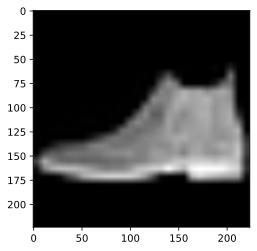

In [38]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

for i, data in enumerate(val_loader) :
    if i <1:
        X, y = data[0], data[1]
        print(X,y)
        #plt.title(labels_map[y[0].to(device)])
        #plt.imshow(  transforms.ToPILImage(X[0]))  
        plt.imshow(X[0].squeeze(), cmap="gray")
    else:
        exit

plt.imshow(X[0].squeeze(), cmap="gray")

"""
   
 fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root=".").train_data.float()
# eval on our pig image
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([  # 
       transforms.Resize(224), #min size for pytorch
       transforms.ToTensor(),
       transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,)),
    ])
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
#figure = plt.figure(figsize=(8, 8))
cols, rows = 1, 1
#for i in range(1, cols * rows + 1):
#    sample_idx = torch.randint(len(training_data), size=(1,)).item()
sample_idx=9406
img, label = training_data[sample_idx]
    #figure.add_subplot(rows, cols, i)
plt.title(labels_map[label])
img_tensor = img[None,:,:,:]
#plt.imshow(img_tensor[0].numpy().transpose(1,2,0))
plt.imshow(img.squeeze(), cmap="gray")

"""


In [40]:
#norm = transforms.Compose([
#         transforms.ToTensor(),
#        transforms.Normalize((training_data.train_data.float().mean()/255,), 
#                            (training_data.train_data.float().std()/255,)),
#])

pred = model(X[0].unsqueeze(0).cuda())

In [42]:
pred
#print(labels_map[pred.max(dim=1)[1].item()])

tensor([[ 0.0846, -0.5368,  0.3481, -0.0854, -0.5416, -0.2399,  0.6279,  0.1358,
         -0.1966, -0.0821]], device='cuda:0', grad_fn=<AddmmBackward>)

FROM HERE ONWARD WE INVESTIGATE PGD attack. DO Not train the model , just reload it from disk. 
Always re-run the imports(first cell in notebook) 

In [10]:
model = MnistResNet()
model_state_dict = torch.load("./MnistResNet")
model.load_state_dict(model_state_dict)

<All keys matched successfully>